In [45]:
import numpy as np
import pandas as pd
import datetime
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [46]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_hist_trans = pd.read_csv('../input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv')

In [47]:
df_hist_trans['purchase_amount'] = np.exp(df_hist_trans['purchase_amount'])
df_new_merchant_trans['purchase_amount'] = np.exp(df_new_merchant_trans['purchase_amount'])

In [48]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [49]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [50]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [51]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

175

In [52]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

28

In [53]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,9,23,35,7,...,6.0,0.260870,0.0,0.000000,23.0,1.658319e+108,1.381361e+36,54.0,2.347826,238.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,12,24,50,7,...,0.0,0.000000,0.0,0.000000,6.0,1.658319e+108,3.557623e+25,56.0,9.333333,268.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,10,14,22,7,...,1.0,1.000000,0.0,0.000000,1.0,7.789907e+26,1.381361e+36,0.0,0.000000,239.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,6,16,20,7,...,3.0,0.428571,1.0,0.142857,7.0,2.369028e+107,1.973373e+35,41.0,5.857143,249.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,4,22,17,7,...,12.0,0.333333,2.0,0.055556,36.0,1.842577e+107,3.624714e+107,57.0,1.583333,239.0


In [54]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [55]:
list_outlier_idx = df_train[df_train.outliers == 1].index.tolist()

In [56]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [57]:
high_importance_features = [
    "hist_month_diff_mean", 
    "hist_authorized_flag_mean", 
    "hist_category_1_sum", 
    "hist_month_lag_mean", 
    "new_hist_purchase_amount_sum", 
    "new_hist_purchase_date_uptonow"
]

#smoothing
for col in high_importance_features:
    df_train[col] = np.where(df_train[col].values==0, 0.001, df_train[col].values)
    df_test[col] = np.where(df_test[col].values==0, 0.001, df_test[col].values)


for i in range(len(high_importance_features)):
    for j in range(len((high_importance_features)))[i+1:]:
        col1 = high_importance_features[i]
        col2 = high_importance_features[j]
        new_col_name = "{c1}__div__{c2}".format(c1=col1, c2=col2)
        
        df_train[new_col_name] = df_train[col1] / df_train[col2]
        df_test[new_col_name] = df_test[col1] / df_test[col2]

In [58]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [59]:
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/new_merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/prosperity_merchants_latest.csv")
df_train, df_test = merge_new_feature("../input/merchants_numerical_features.csv")
df_train, df_test = merge_new_feature("../input/merchants_item_scale_feature.csv")
df_train, df_test = merge_new_feature("../input/purchase_pattern.csv")
df_train, df_test = merge_new_feature("../input/purchase_pettern_nmf.csv")
df_train, df_test = merge_new_feature("../input/purchase_amount_pettern_nmf.csv")
df_train, df_test = merge_new_feature("../input/merchants_category.csv")
df_train, df_test = merge_new_feature("../input/fifa_score.csv")

In [60]:
df_train["Null_count"] = df_train.isnull().sum(axis=1)
df_test["Null_count"] = df_test.isnull().sum(axis=1)

In [61]:
dont_use = ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers', 'category_1_Y_std']

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['target']
target_outlier = df_train["outliers"]

In [62]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.73847	valid_1's rmse: 3.77527
[200]	training's rmse: 3.66971	valid_1's rmse: 3.7343
[300]	training's rmse: 3.62117	valid_1's rmse: 3.71187
[400]	training's rmse: 3.5838	valid_1's rmse: 3.69852
[500]	training's rmse: 3.55405	valid_1's rmse: 3.68874
[600]	training's rmse: 3.52982	valid_1's rmse: 3.68151
[700]	training's rmse: 3.50883	valid_1's rmse: 3.67654
[800]	training's rmse: 3.49013	valid_1's rmse: 3.67256
[900]	training's rmse: 3.47324	valid_1's rmse: 3.66921
[1000]	training's rmse: 3.45769	valid_1's rmse: 3.66638
[1100]	training's rmse: 3.44303	valid_1's rmse: 3.66379
[1200]	training's rmse: 3.42954	valid_1's rmse: 3.6616
[1300]	training's rmse: 3.41652	valid_1's rmse: 3.65955
[1400]	training's rmse: 3.40436	valid_1's rmse: 3.65822
[1500]	training's rmse: 3.39217	valid_1's rmse: 3.65668
[1600]	training's rmse: 3.38069	valid_1's rmse: 3.65549
[1700]	training's rmse: 3.3696	valid_1's rmse:

[700]	training's rmse: 3.5008	valid_1's rmse: 3.68149
[800]	training's rmse: 3.48168	valid_1's rmse: 3.67924
[900]	training's rmse: 3.46454	valid_1's rmse: 3.6775
[1000]	training's rmse: 3.44872	valid_1's rmse: 3.67624
[1100]	training's rmse: 3.43357	valid_1's rmse: 3.67514
[1200]	training's rmse: 3.41966	valid_1's rmse: 3.67406
[1300]	training's rmse: 3.40663	valid_1's rmse: 3.67327
[1400]	training's rmse: 3.39422	valid_1's rmse: 3.67258
[1500]	training's rmse: 3.38249	valid_1's rmse: 3.67208
[1600]	training's rmse: 3.37105	valid_1's rmse: 3.67147
[1700]	training's rmse: 3.35998	valid_1's rmse: 3.67114
[1800]	training's rmse: 3.34931	valid_1's rmse: 3.67066
[1900]	training's rmse: 3.33936	valid_1's rmse: 3.67036
[2000]	training's rmse: 3.32891	valid_1's rmse: 3.67008
[2100]	training's rmse: 3.3193	valid_1's rmse: 3.6696
[2200]	training's rmse: 3.30991	valid_1's rmse: 3.66954
[2300]	training's rmse: 3.3009	valid_1's rmse: 3.66928
[2400]	training's rmse: 3.29188	valid_1's rmse: 3.66923


3.646350936707032

In [63]:
# score:  3.6467757129353053

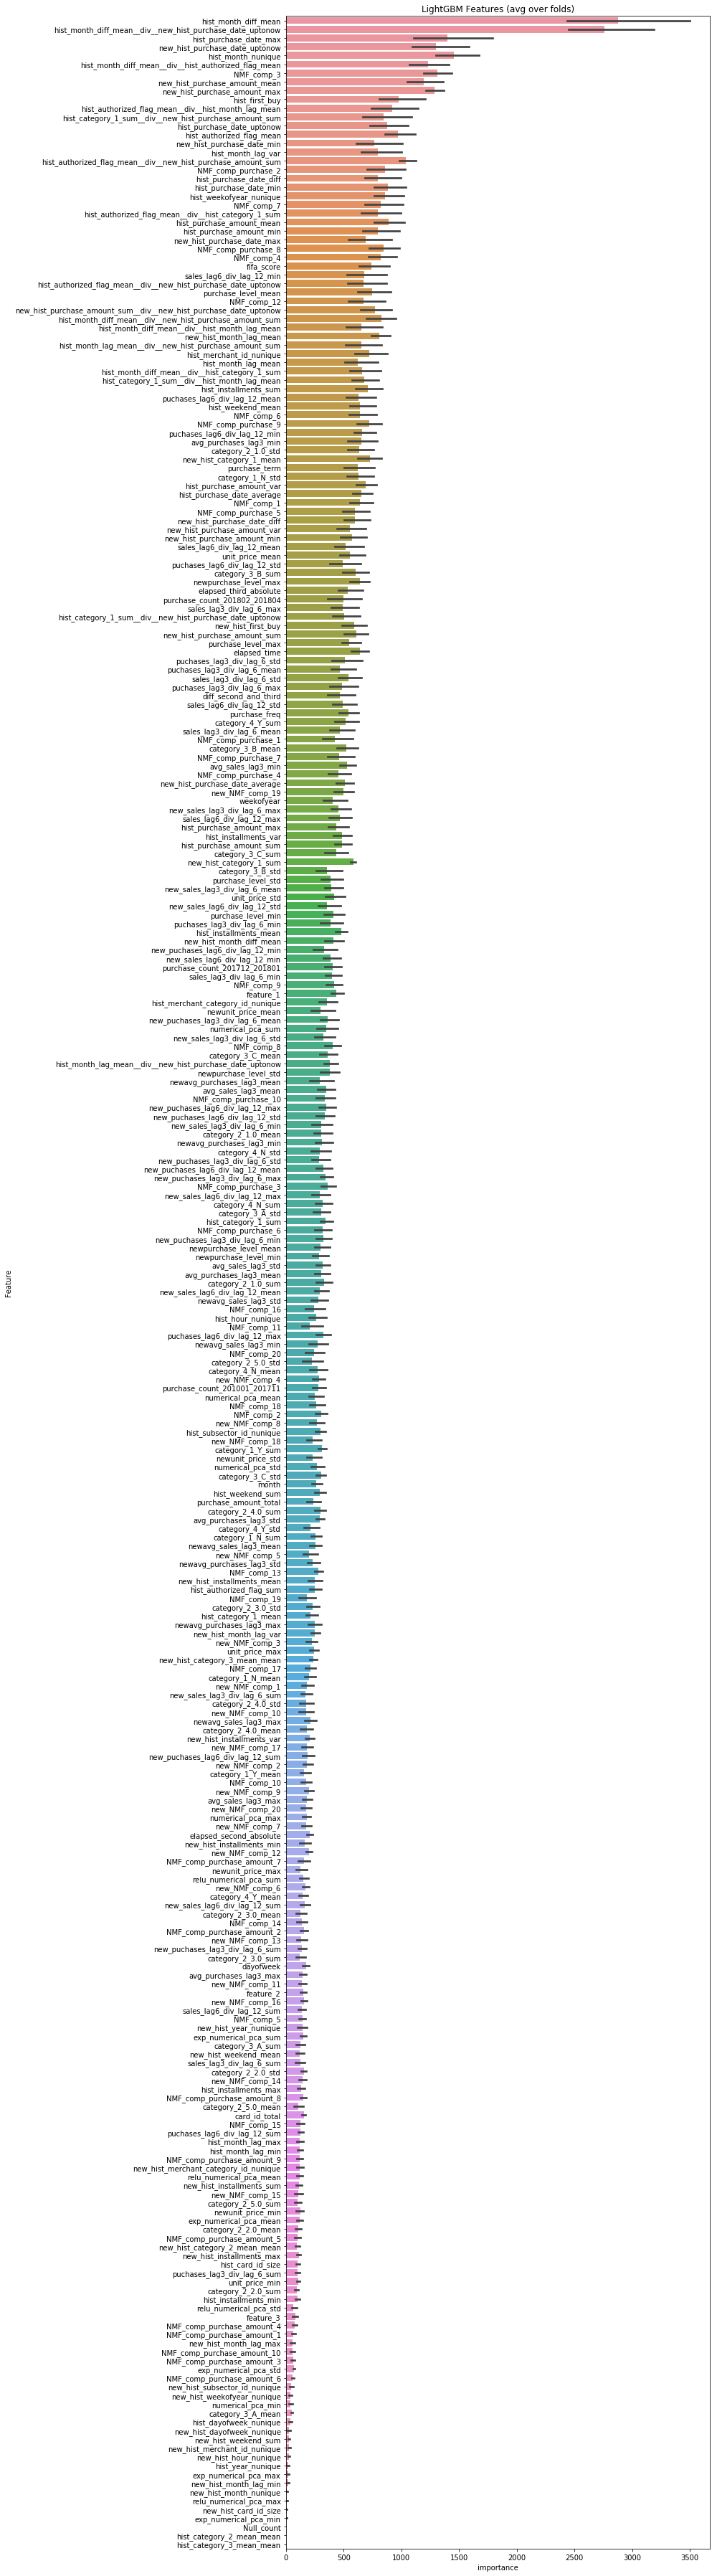

In [64]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [65]:
df_train2 = df_train[df_train.target >= -20].reset_index(drop=True)
target2 = df_train2["target"]

#original
param2 = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train2))
predictions2 = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train2,df_train2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train2.iloc[trn_idx][df_train_columns], label=target2.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train2.iloc[val_idx][df_train_columns], label=target2.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param2, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions2 += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target2))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.65324	valid_1's rmse: 1.65216
[200]	training's rmse: 1.61841	valid_1's rmse: 1.61777
[300]	training's rmse: 1.59795	valid_1's rmse: 1.59837
[400]	training's rmse: 1.58466	valid_1's rmse: 1.58623
[500]	training's rmse: 1.57519	valid_1's rmse: 1.57824
[600]	training's rmse: 1.568	valid_1's rmse: 1.57268
[700]	training's rmse: 1.56218	valid_1's rmse: 1.56863
[800]	training's rmse: 1.55725	valid_1's rmse: 1.56556
[900]	training's rmse: 1.5529	valid_1's rmse: 1.56321
[1000]	training's rmse: 1.54893	valid_1's rmse: 1.56123
[1100]	training's rmse: 1.54537	valid_1's rmse: 1.5597
[1200]	training's rmse: 1.54203	valid_1's rmse: 1.55841
[1300]	training's rmse: 1.53895	valid_1's rmse: 1.55742
[1400]	training's rmse: 1.53596	valid_1's rmse: 1.55645
[1500]	training's rmse: 1.53313	valid_1's rmse: 1.55567
[1600]	training's rmse: 1.53048	valid_1's rmse: 1.55501
[1700]	training's rmse: 1.52789	valid_1's rmse:

[8700]	training's rmse: 1.41534	valid_1's rmse: 1.5409
[8800]	training's rmse: 1.41399	valid_1's rmse: 1.54089
[8900]	training's rmse: 1.4126	valid_1's rmse: 1.54089
[9000]	training's rmse: 1.41123	valid_1's rmse: 1.54088
[9100]	training's rmse: 1.40989	valid_1's rmse: 1.54087
[9200]	training's rmse: 1.40855	valid_1's rmse: 1.54085
[9300]	training's rmse: 1.40724	valid_1's rmse: 1.54086
[9400]	training's rmse: 1.4059	valid_1's rmse: 1.54089
[9500]	training's rmse: 1.40451	valid_1's rmse: 1.5409
[9600]	training's rmse: 1.40311	valid_1's rmse: 1.54088
Early stopping, best iteration is:
[9215]	training's rmse: 1.40835	valid_1's rmse: 1.54084
fold 2
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.65222	valid_1's rmse: 1.65498
[200]	training's rmse: 1.61724	valid_1's rmse: 1.62154
[300]	training's rmse: 1.59678	valid_1's rmse: 1.60276
[400]	training's rmse: 1.58348	valid_1's rmse: 1.5913
[500]	training's rmse: 1.57415	valid_1's rmse: 1.58386
[600]	tra

[5800]	training's rmse: 1.45434	valid_1's rmse: 1.5562
[5900]	training's rmse: 1.45279	valid_1's rmse: 1.55617
[6000]	training's rmse: 1.45127	valid_1's rmse: 1.55618
[6100]	training's rmse: 1.44975	valid_1's rmse: 1.55617
[6200]	training's rmse: 1.44824	valid_1's rmse: 1.5562
Early stopping, best iteration is:
[5872]	training's rmse: 1.45324	valid_1's rmse: 1.55615
fold 4
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.64761	valid_1's rmse: 1.67458
[200]	training's rmse: 1.61268	valid_1's rmse: 1.64158
[300]	training's rmse: 1.59219	valid_1's rmse: 1.62296
[400]	training's rmse: 1.57898	valid_1's rmse: 1.6115
[500]	training's rmse: 1.56956	valid_1's rmse: 1.60388
[600]	training's rmse: 1.56242	valid_1's rmse: 1.59856
[700]	training's rmse: 1.55668	valid_1's rmse: 1.59468
[800]	training's rmse: 1.5518	valid_1's rmse: 1.5918
[900]	training's rmse: 1.54743	valid_1's rmse: 1.58937
[1000]	training's rmse: 1.54346	valid_1's rmse: 1.58739
[1100]	traini

1.5561103238766143

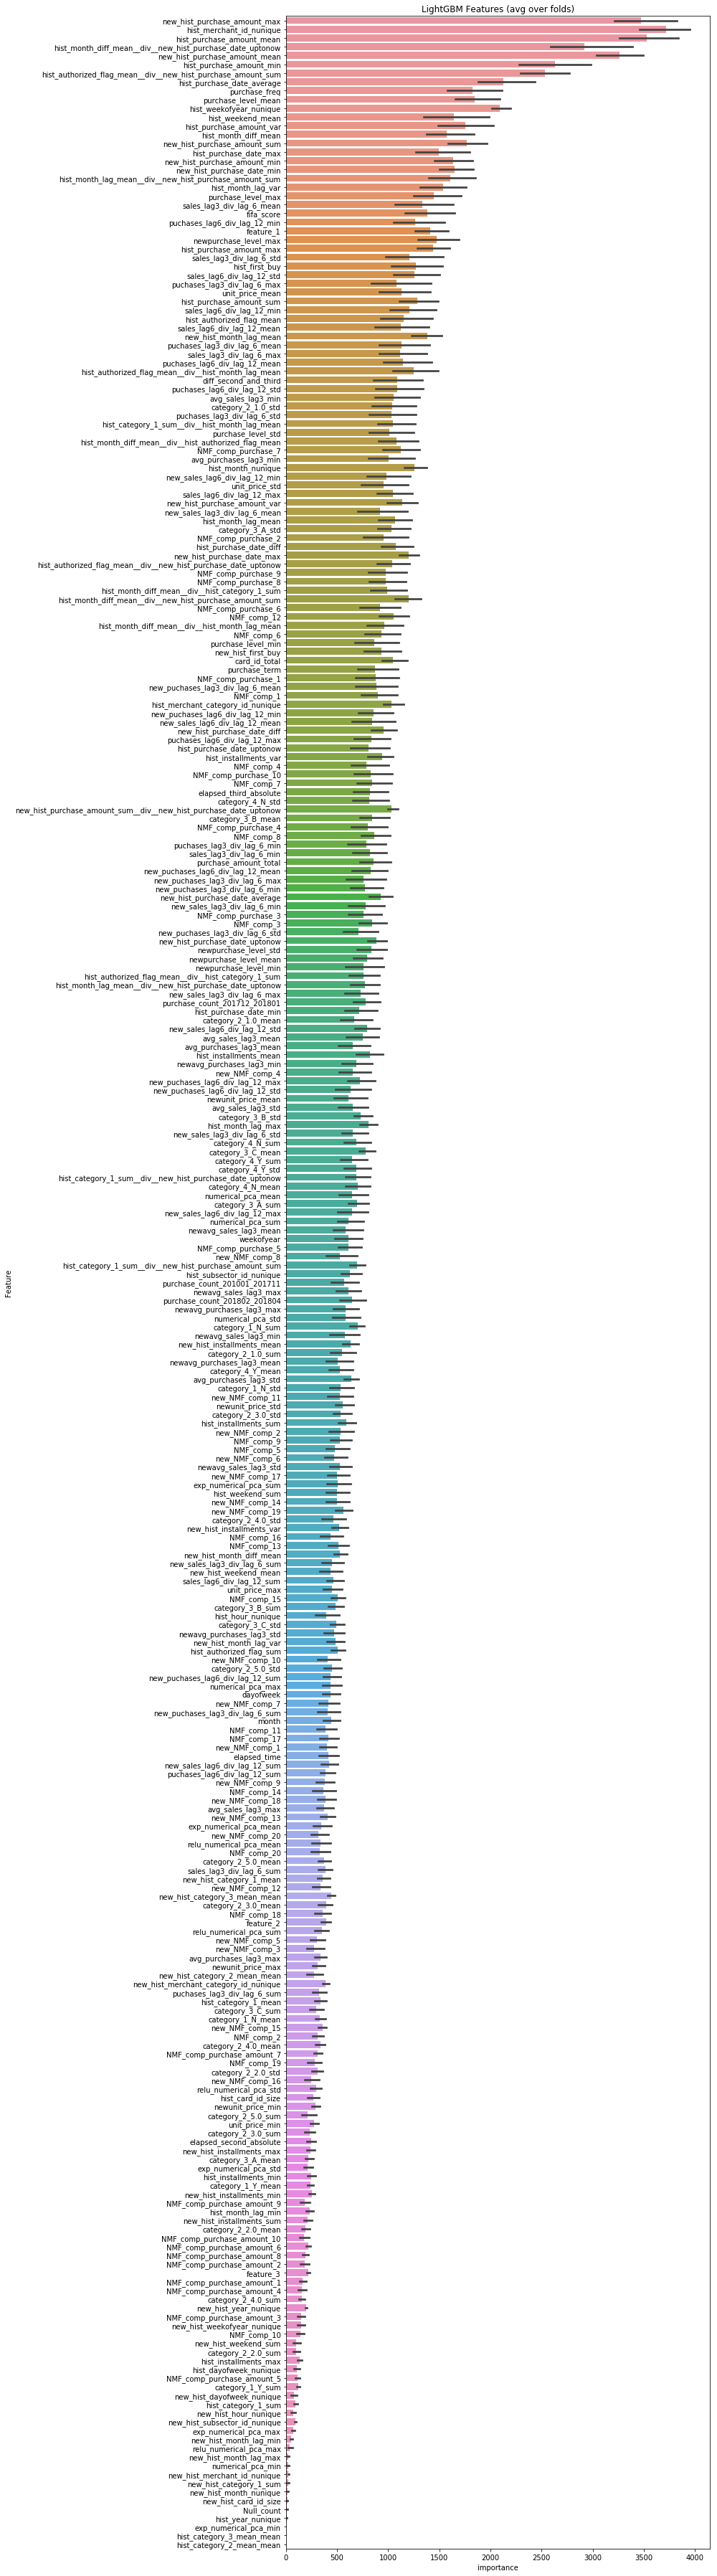

In [71]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [72]:
df_prediction = pd.DataFrame({"prediction1":predictions, "prediction2":predictions2})
df_prediction

,prediction1,prediction2
0,-1.937111,-0.510971
1,-0.298129,-0.301668
2,-0.937339,-0.485457
3,-0.086344,-0.075307
4,-1.507903,-1.774148
5,0.089216,0.600953
6,0.046450,0.167468
7,0.560386,0.833134
8,-0.662563,-0.689688
9,-1.118262,-0.305427


In [73]:
predictions3 = np.zeros(df_prediction.shape[0])
for i, r in df_prediction.iterrows():
    if r[0] < 0 :
        predictions3[i] = r[0]
    else:
        predictions3[i] = r[1]
df_prediction["prediction3"] = predictions3

In [74]:
df_prediction

,prediction1,prediction2,prediction3
0,-1.937111,-0.510971,-1.937111
1,-0.298129,-0.301668,-0.298129
2,-0.937339,-0.485457,-0.937339
3,-0.086344,-0.075307,-0.086344
4,-1.507903,-1.774148,-1.507903
5,0.089216,0.600953,0.600953
6,0.046450,0.167468,0.167468
7,0.560386,0.833134,0.833134
8,-0.662563,-0.689688,-0.662563
9,-1.118262,-0.305427,-1.118262


In [75]:
final_predictions = df_prediction.prediction3.values

In [76]:
# import optuna

# def objective(trial):
#     train_x, test_x, train_y, test_y = train_test_split(df_train[df_train_columns], target, test_size=0.20, random_state=4590)
    
#     dtrain = lgb.Dataset(train_x, label=train_y)
#     dval = lgb.Dataset(test_x, label=test_y)

#     num_round = trial.suggest_int('num_round', 1, 10000)
#     param = {
#         'objective': 'regression', 
#         'metric': 'rmse',
#         'verbosity': -1,
#         'feature_fraction': trial.suggest_loguniform('feature_fraction', 0.8, 0.95),
#         'bagging_fraction': trial.suggest_loguniform('bagging_fraction', 0.8, 0.95),
#         'bagging_seed': 11,
#         'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
#         'num_leaves': trial.suggest_int('num_leaves', 10, 100),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
#         'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
#         'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 10, 1000),
#         'lambda_l1':  trial.suggest_loguniform('lambda_l1', 1e-2, 1.0)
#     }

#     if param['boosting_type'] == 'dart':
#         param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-4, 1.0)
#         param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-4, 1.0)
#     if param['boosting_type'] == 'goss':
#         param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
#         param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])

#     gbm = lgb.train(param, dtrain, num_round, valid_sets = [dtrain, dval], verbose_eval=100, early_stopping_rounds=400)
#     preds = gbm.predict(test_x)
#     pred_labels = np.rint(preds)
#     rmse = np.sqrt(mean_squared_error(test_y, pred_labels))
#     return rmse

# study = optuna.create_study()
# study.optimize(objective, n_trials=20)

# print('Number of finished trials: {}'.format(len(study.trials)))

# print('Best trial:')
# trial = study.best_trial

# print('  Value: {}'.format(trial.value))

# print('  Params: ')
# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))

In [77]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = final_predictions
sub_df.to_csv("../output/submission_model20181223.csv", index=False)